In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns







In [2]:
df = pd.read_csv("data/traffic_weather_merged.csv")
df.head()



,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,night,...,timezone,v85,street_name,temperature_c,precipitation_mm,rain_mm,snowfall_cm,cloud_cover_pct,wind_speed_kmh,sunshine_duration_s
0,-1,9000008372,2025-11-21 09:00:00+01:00,hourly,0.499722,0.0,34.0,4.0,4.0,0.0,...,Europe/Paris,27.5,Sintmartenslatemlaan,0.2,0.0,0.0,0.0,100,12.2,6.59
1,-1,9000008372,2025-11-21 10:00:00+01:00,hourly,0.999444,0.0,39.0,11.0,6.0,0.0,...,Europe/Paris,25.5,Sintmartenslatemlaan,0.8,0.0,0.0,0.0,100,13.4,3600.00
2,-1,9000008372,2025-11-21 11:00:00+01:00,hourly,0.999167,2.0,31.0,16.0,6.0,0.0,...,Europe/Paris,29.5,Sintmartenslatemlaan,1.3,0.0,0.0,0.0,100,11.0,672.91
3,-1,9000008372,2025-11-21 12:00:00+01:00,hourly,0.999722,1.0,47.0,30.0,20.0,0.0,...,Europe/Paris,32.5,Sintmartenslatemlaan,2.4,0.0,0.0,0.0,98,9.6,3600.00
4,-1,9000008372,2025-11-21 13:00:00+01:00,hourly,0.999167,1.0,26.0,19.0,36.0,0.0,...,Europe/Paris,35.5,Sintmartenslatemlaan,2.6,0.0,0.0,0.0,100,9.2,3600.00


In [4]:
# convert ISO timestamp string to real datetime
df["datetime"] = pd.to_datetime(df["date"])  # your date column already has timestamp
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Mon
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df[["datetime", "hour", "dayofweek", "is_weekend"]].head()

,datetime,hour,dayofweek,is_weekend
0,2025-11-21 09:00:00+01:00,9,4,0
1,2025-11-21 10:00:00+01:00,10,4,0
2,2025-11-21 11:00:00+01:00,11,4,0
3,2025-11-21 12:00:00+01:00,12,4,0
4,2025-11-21 13:00:00+01:00,13,4,0


In [5]:
holidays = pd.read_csv("data/belgian_holidays.csv")
holidays["date"] = pd.to_datetime(holidays["date"]).dt.date
holidays["is_holiday"] = 1

vac = pd.read_csv("data/school_vacations.csv")
vac["date"] = pd.to_datetime(vac["date"]).dt.date
vac["is_school_vacation"] = 1

df = df.merge(holidays[["date", "is_holiday"]],
              left_on="date_only", right_on="date", how="left")
df = df.merge(vac[["date", "is_school_vacation"]],
              left_on="date_only", right_on="date", how="left")

df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)
df["is_school_vacation"] = df["is_school_vacation"].fillna(0).astype(int)

df[["datetime","is_holiday","is_school_vacation"]].head()


,datetime,is_holiday,is_school_vacation
0,2025-11-21 09:00:00+01:00,0,0
1,2025-11-21 10:00:00+01:00,0,0
2,2025-11-21 11:00:00+01:00,0,0
3,2025-11-21 12:00:00+01:00,0,0
4,2025-11-21 13:00:00+01:00,0,0


In [6]:
# simple label encoding for two streets
df["street_code"] = df["street_name"].astype("category").cat.codes


In [8]:
df["total_people"] = (
    df["car"] + df["bike"] + df["pedestrian"] +df["heavy"]
)


In [9]:
feature_cols = [
    "hour","dayofweek","is_weekend",
    "is_holiday","is_school_vacation",
    "temperature_c","precipitation_mm",
    "cloud_cover_pct","wind_speed_kmh",
    "street_code",
]

df_model = df.dropna(subset=feature_cols)

X = df_model[feature_cols]

targets = ["car", "bike", "heavy", "pedestrian", "total_people"]
models = {}
metrics = {}

In [10]:
for t in targets:
    y = df_model[t]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    models[t] = rf
    metrics[t] = {"mae": mae, "rmse": rmse}

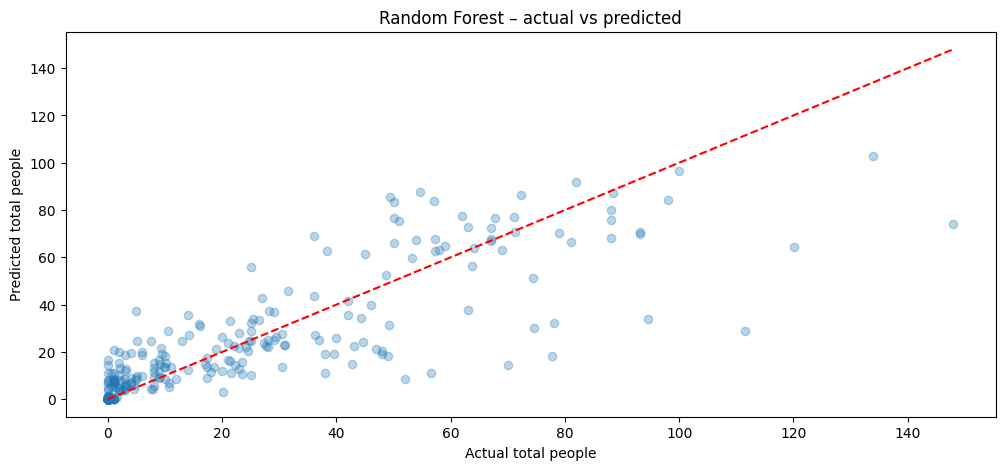

In [11]:
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual total people")
plt.ylabel("Predicted total people")
plt.title("Random Forest – actual vs predicted")
plt.show()


In [12]:
import numpy as np

importances = rf.feature_importances_
for name, val in sorted(zip(X.columns, importances),
                        key=lambda x: x[1], reverse=True):
    print(f"{name}: {val:.3f}")


hour: 0.443
street_code: 0.194
temperature_c: 0.084
dayofweek: 0.073
wind_speed_kmh: 0.070
is_school_vacation: 0.070
is_weekend: 0.032
cloud_cover_pct: 0.024
precipitation_mm: 0.008
is_holiday: 0.002


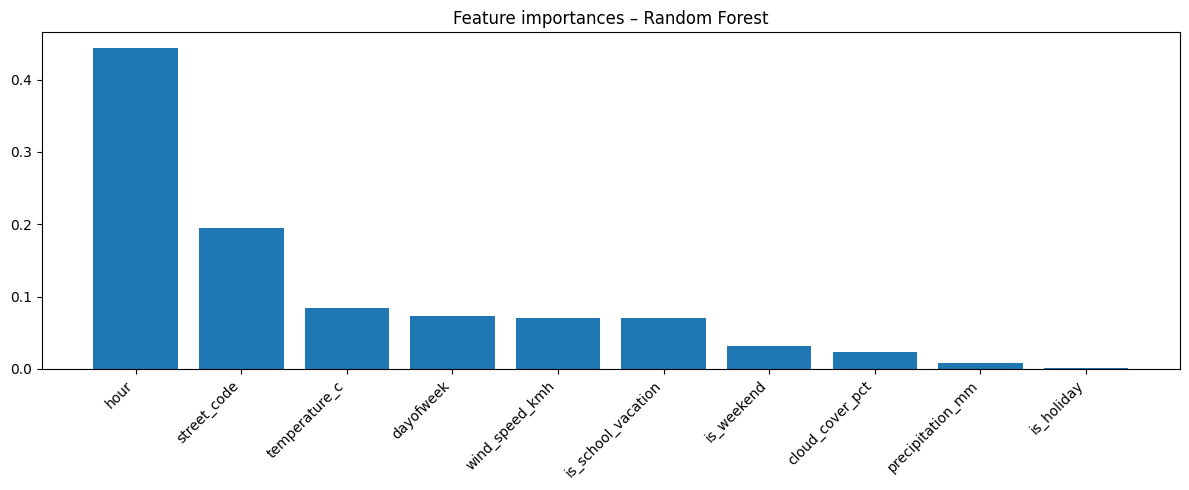

In [13]:
plt.figure(figsize=(12,5))
idx = np.argsort(importances)[::-1]
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), X.columns[idx], rotation=45, ha="right")
plt.title("Feature importances – Random Forest")
plt.tight_layout()
plt.show()


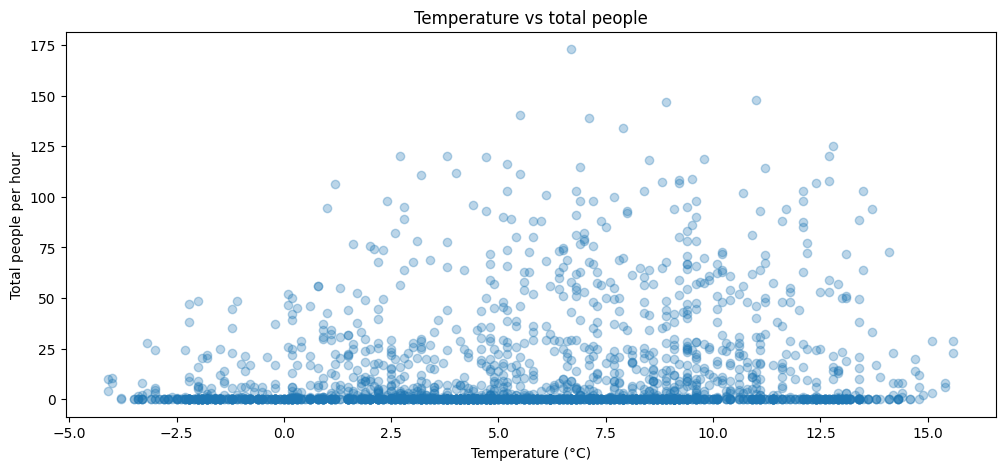

In [15]:
plt.figure(figsize=(12,5))
plt.scatter(df_model["temperature_c"], df_model["total_people"], alpha=0.3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Total people per hour")
plt.title("Temperature vs total people")
plt.show()


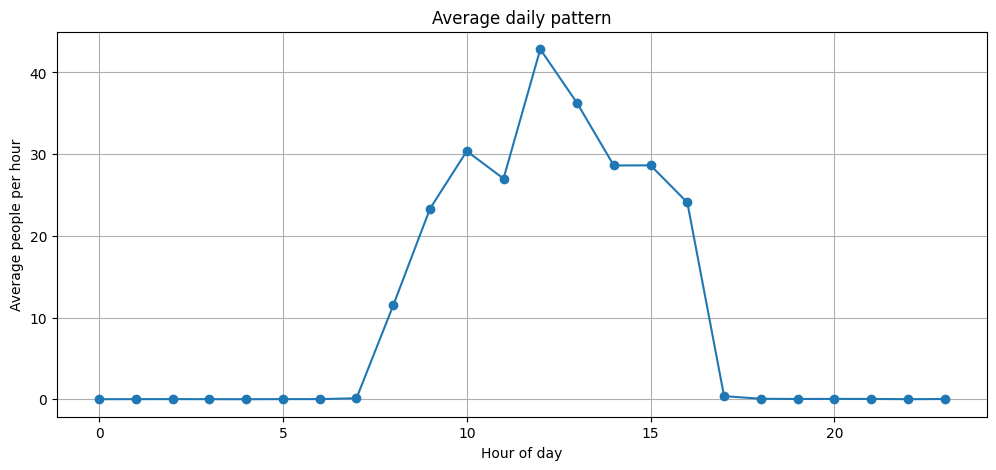

In [16]:
avg_by_hour = df_model.groupby("hour")["total_people"].mean()

plt.figure(figsize=(12,5))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Average people per hour")
plt.title("Average daily pattern")
plt.grid(True)
plt.show()


In [17]:
avg_by_group = df_model.groupby(
    ["is_holiday", "is_school_vacation"]
)["total_people"].mean().reset_index()

print(avg_by_group)


   is_holiday  is_school_vacation  total_people
0           0                   0     12.300020
1           0                   1      6.990931
2           1                   0      4.291667
3           1                   1      3.040411


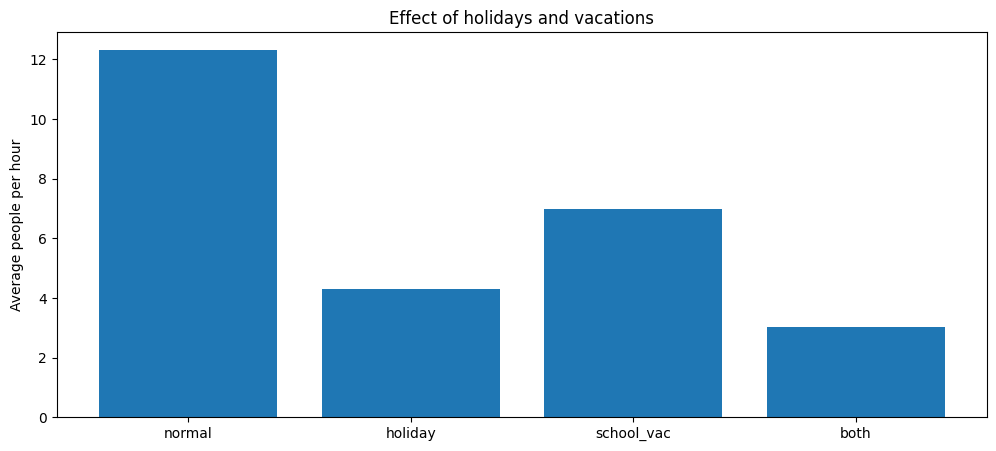

In [18]:
labels = ["normal", "holiday", "school_vac", "both"]
avg_vals = []

for h, v in [(0,0), (1,0), (0,1), (1,1)]:
    avg_vals.append(
        df_model[
            (df_model["is_holiday"]==h) &
            (df_model["is_school_vacation"]==v)
        ]["total_people"].mean()
    )

plt.figure(figsize=(12,5))
plt.bar(labels, avg_vals)
plt.ylabel("Average people per hour")
plt.title("Effect of holidays and vacations")
plt.show()


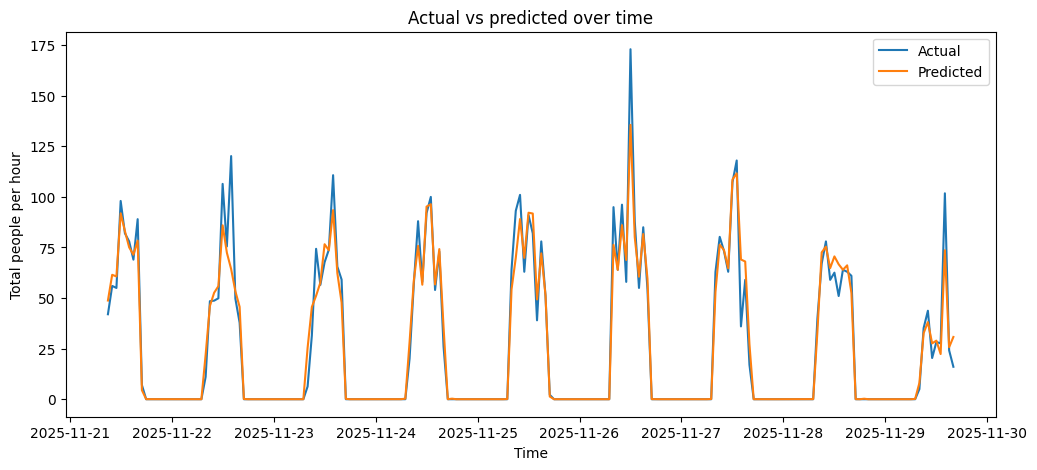

In [19]:
sample = df_model.iloc[:200].copy()
sample_X = sample[feature_cols]
sample["pred_total"] = rf.predict(sample_X)

plt.figure(figsize=(12,5))
plt.plot(sample["datetime"], sample["total_people"], label="Actual")
plt.plot(sample["datetime"], sample["pred_total"], label="Predicted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Total people per hour")
plt.title("Actual vs predicted over time")
plt.show()


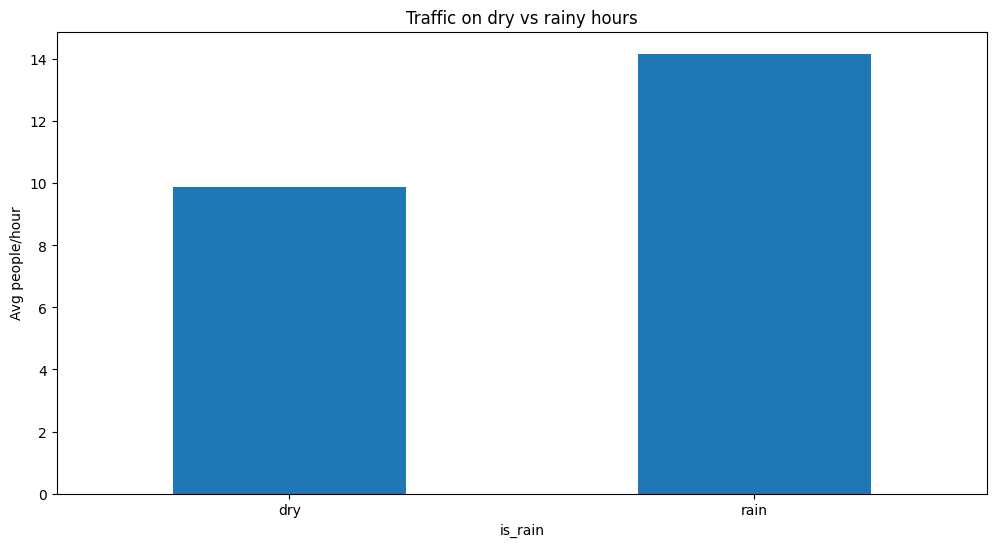

In [20]:
df_model["is_rain"] = (df_model["precipitation_mm"] > 0).astype(int)
avg_rain = df_model.groupby("is_rain")["total_people"].mean()
avg_rain.plot(kind="bar", rot=0 , figsize=(12,6))

plt.xticks([0,1], ["dry", "rain"])
plt.ylabel("Avg people/hour")
plt.title("Traffic on dry vs rainy hours")
plt.show()


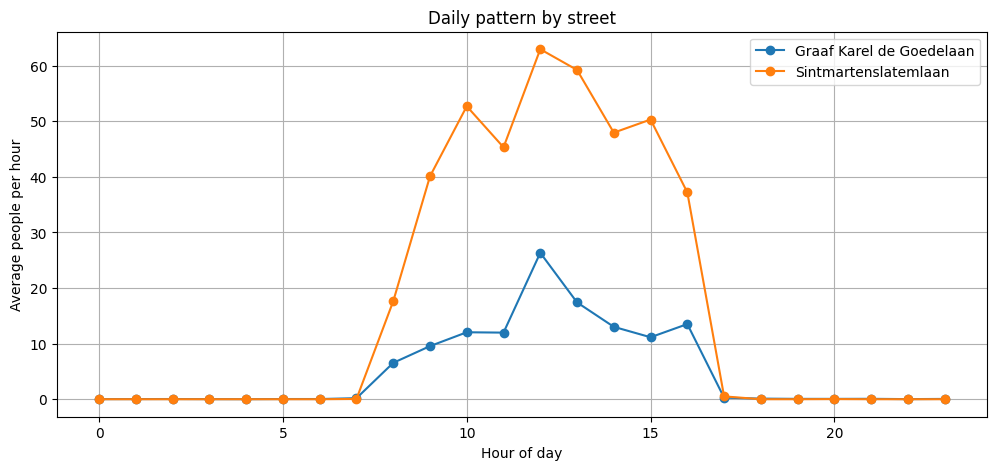

In [21]:
avg_by_hour_street = df_model.groupby(["street_name", "hour"])["total_people"].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for street, group in avg_by_hour_street.groupby("street_name"):
    plt.plot(group["hour"], group["total_people"], marker="o", label=street)

plt.xlabel("Hour of day")
plt.ylabel("Average people per hour")
plt.title("Daily pattern by street")
plt.legend()
plt.grid(True)
plt.show()


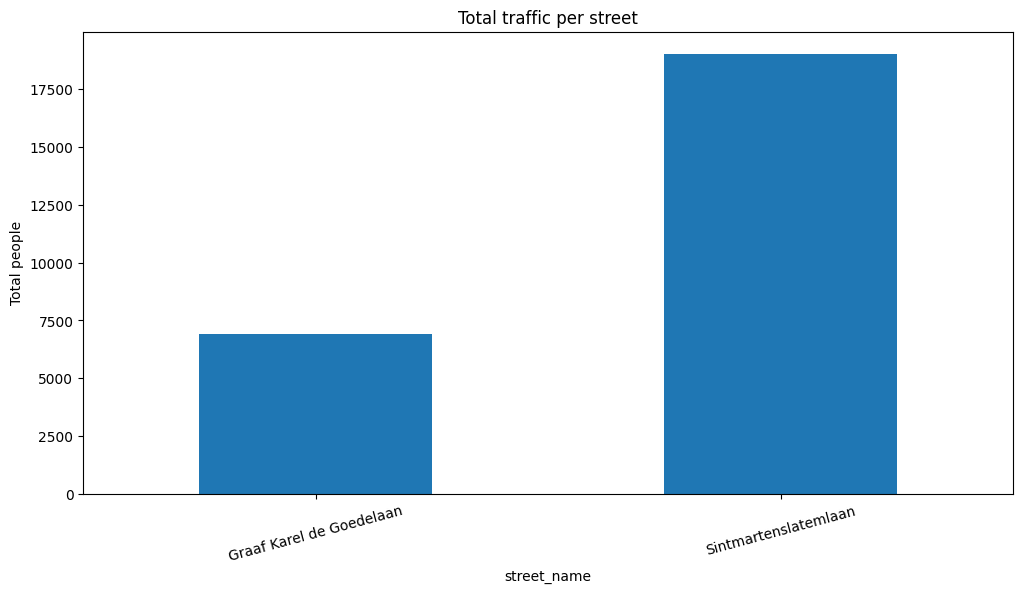

In [22]:
df_model.groupby("street_name")["total_people"].sum().plot(kind="bar", figsize=(12,6))
plt.xticks(rotation=15)

plt.ylabel("Total people")
plt.title("Total traffic per street")
plt.show()


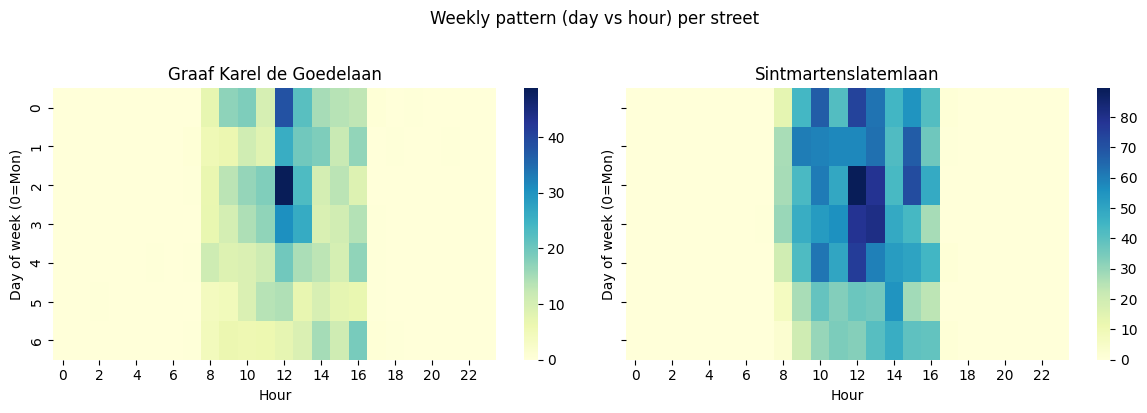

In [25]:
# average per day-of-week and hour, for each street
pivot = (
    df_model.groupby(["street_name","dayofweek","hour"])["total_people"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, (street, sub) in zip(axes, pivot.groupby("street_name")):
    table = sub.pivot(index="dayofweek", columns="hour", values="total_people")
    sns.heatmap(table, ax=ax, cmap="YlGnBu")
    ax.set_title(street)
    ax.set_xlabel("Hour")
    ax.set_ylabel("Day of week (0=Mon)")

fig.suptitle("Weekly pattern (day vs hour) per street", y=1.02)
plt.tight_layout()
plt.show()


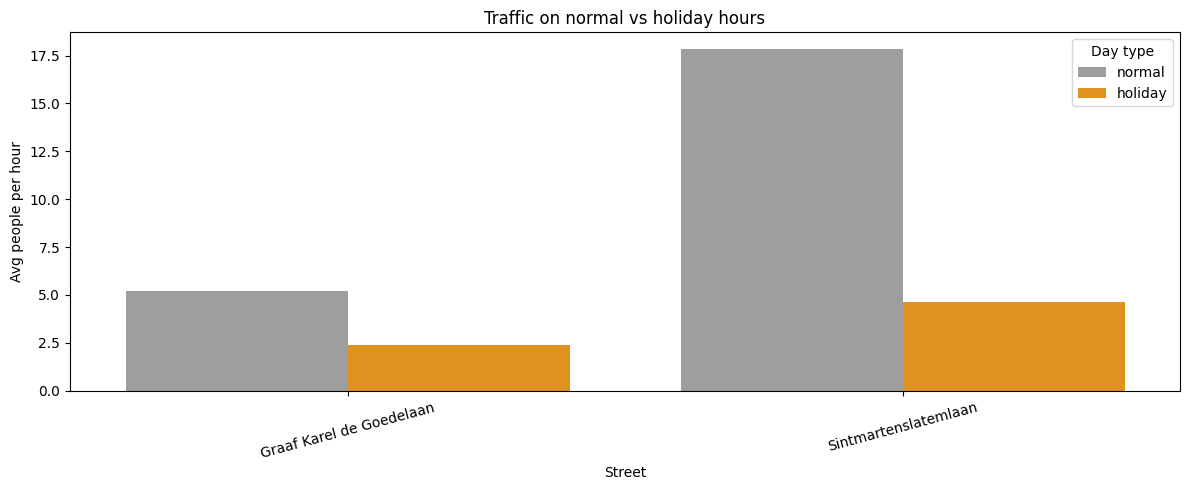

In [27]:
avg_holiday = (
    df_model.groupby(["street_name","is_holiday"])["total_people"]
    .mean()
    .reset_index()
)


plt.figure(figsize=(12,5))
sns.barplot(
    data=avg_holiday,
    x="street_name",
    y="total_people",
    hue="is_holiday",
    palette=["#9E9E9E","#FF9800"]
)
plt.xticks(rotation=15)
plt.xlabel("Street")
plt.ylabel("Avg people per hour")
plt.title("Traffic on normal vs holiday hours")

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["normal", "holiday"], title="Day type")
plt.tight_layout()
plt.show()



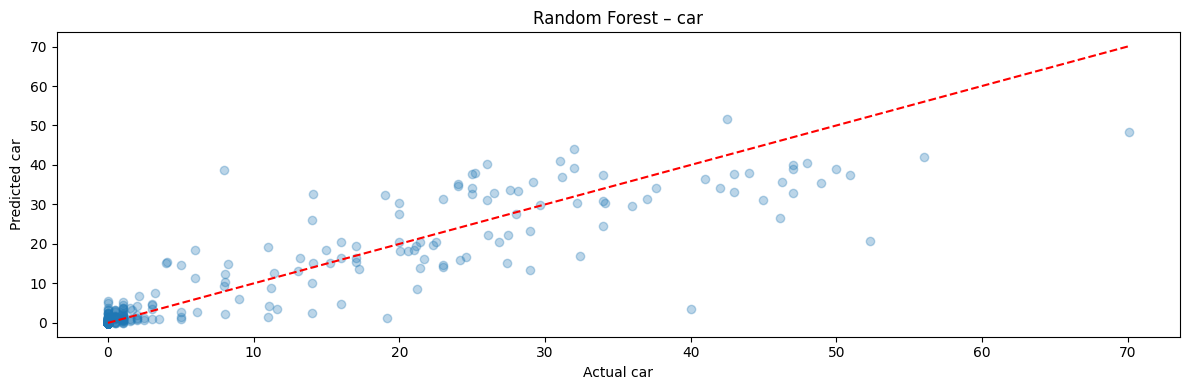

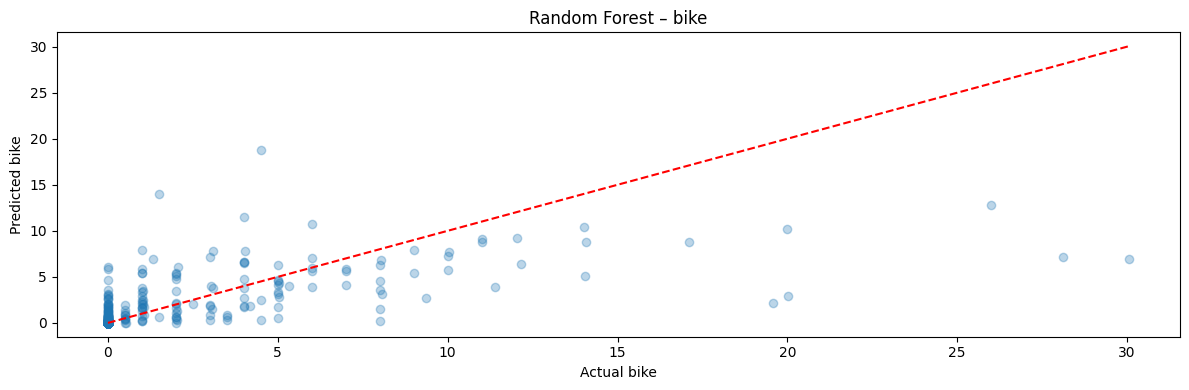

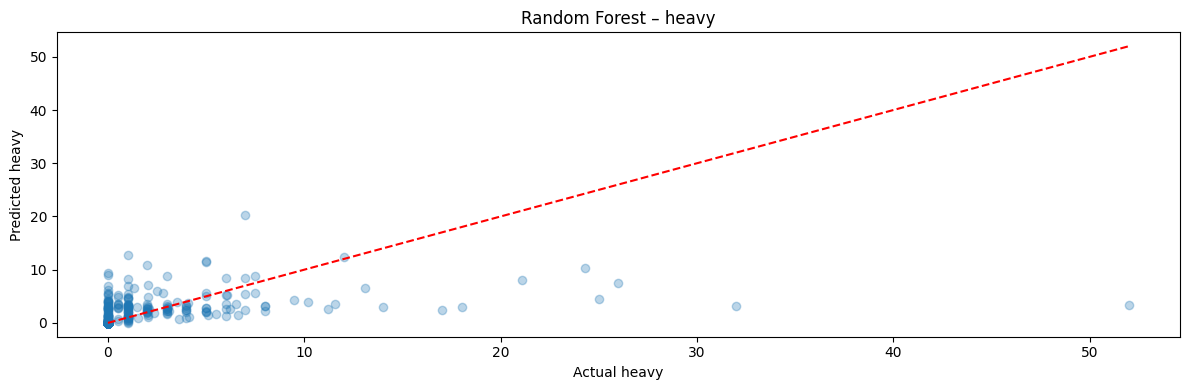

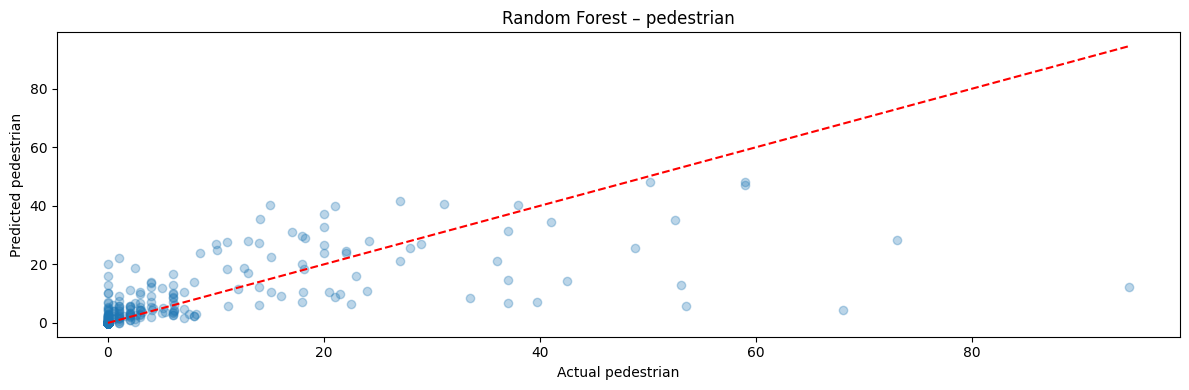

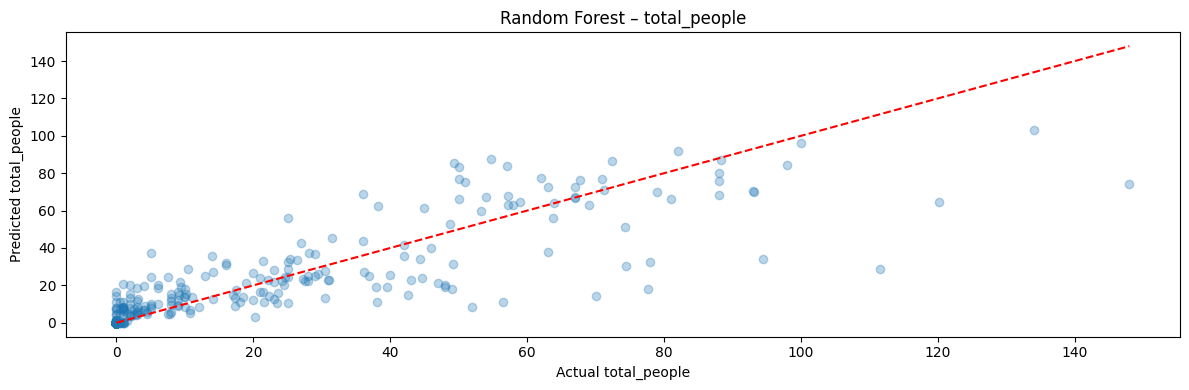

In [31]:
for t in targets:
    rf = models[t]
    y = df_model[t]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    y_pred = rf.predict(X_test)

    plt.figure(figsize=(12,4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
    plt.xlabel(f"Actual {t}")
    plt.ylabel(f"Predicted {t}")
    plt.title(f"Random Forest – {t}")
    plt.tight_layout()
    plt.show()


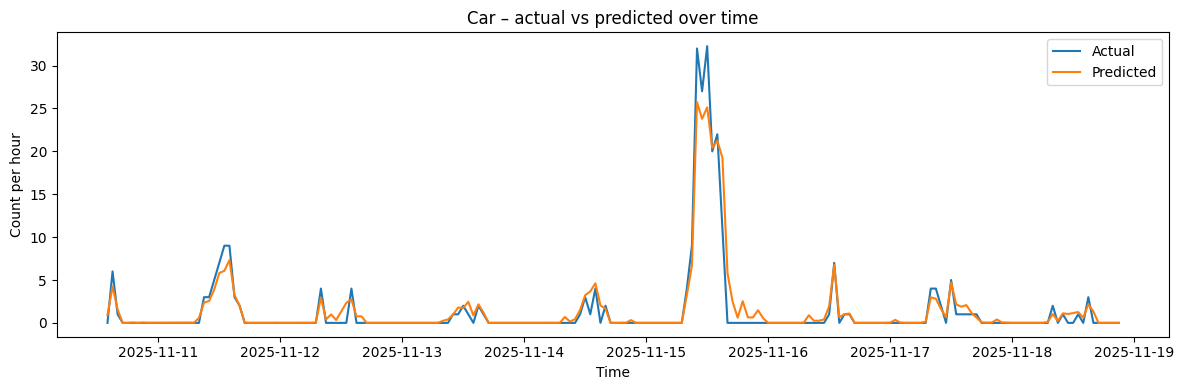

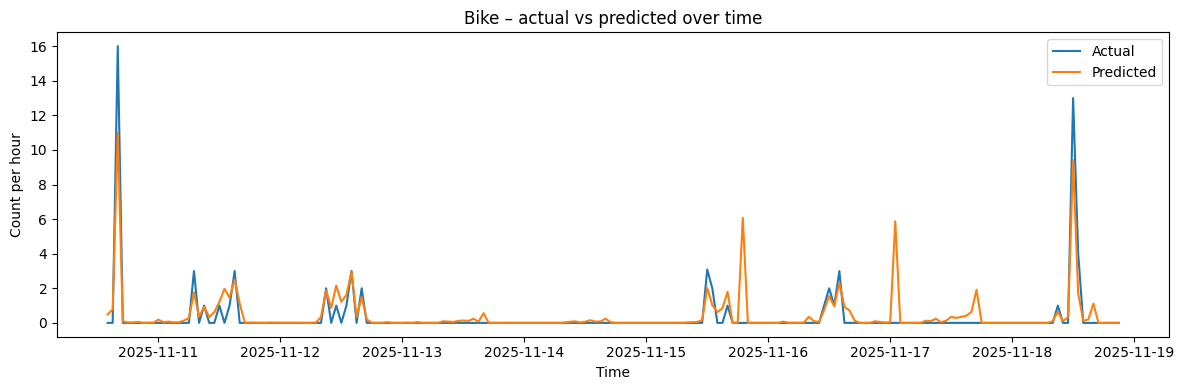

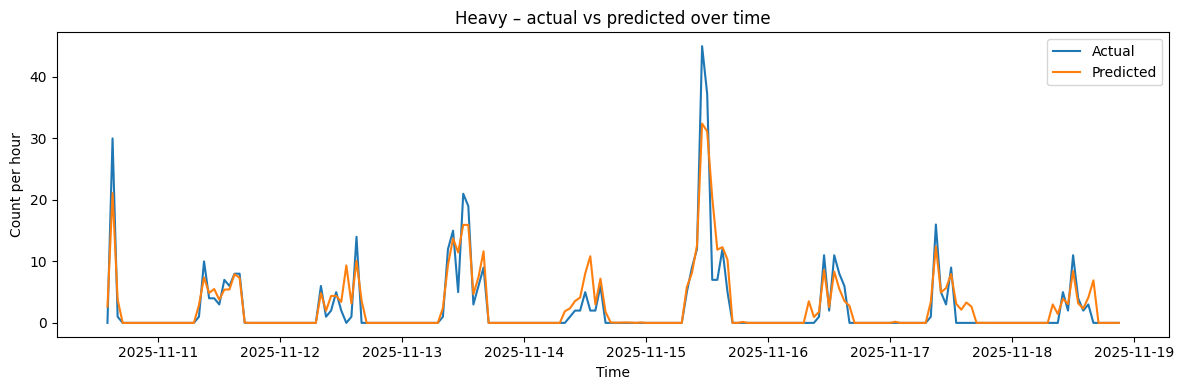

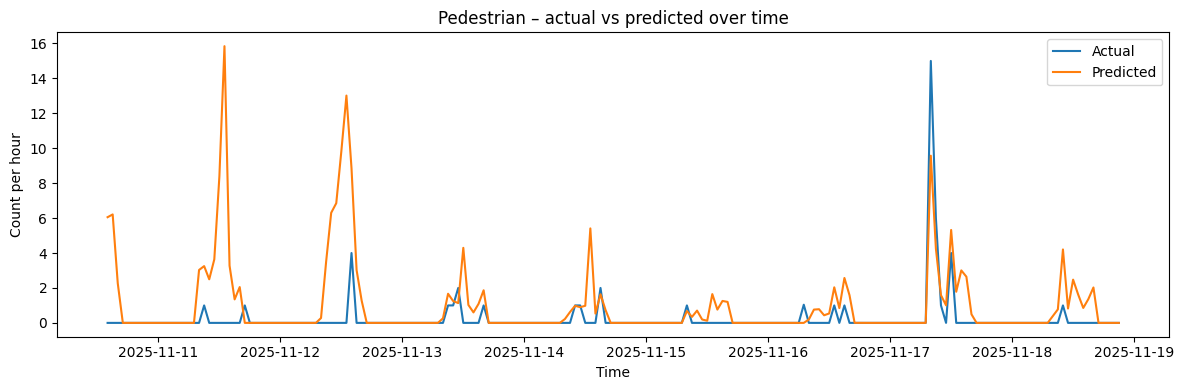

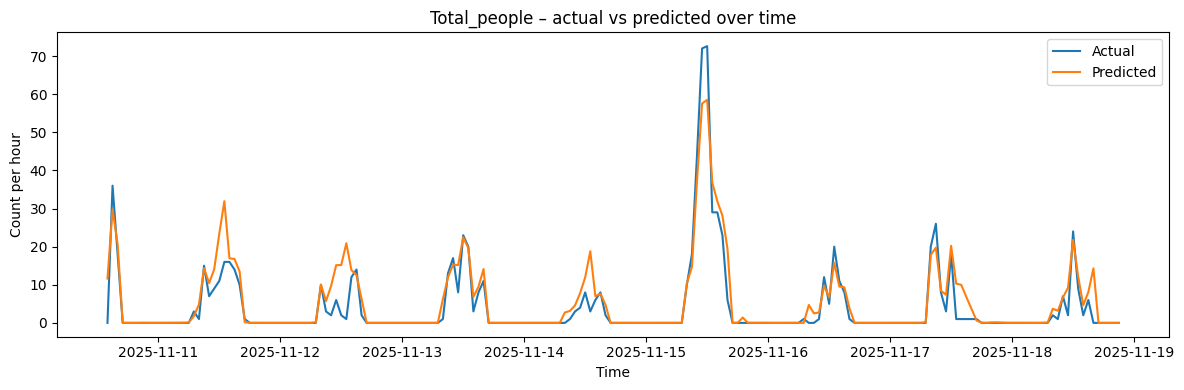

In [33]:
sample = df_model.sort_values("datetime").iloc[:200].copy()

for t in targets:
    rf = models[t]
    sample[f"pred_{t}"] = rf.predict(sample[feature_cols])

    plt.figure(figsize=(12,4))
    plt.plot(sample["datetime"], sample[t], label="Actual")
    plt.plot(sample["datetime"], sample[f"pred_{t}"], label="Predicted")
    plt.title(f"{t.capitalize()} – actual vs predicted over time")
    plt.xlabel("Time")
    plt.ylabel("Count per hour")
    plt.legend()
    plt.tight_layout()
    plt.show()


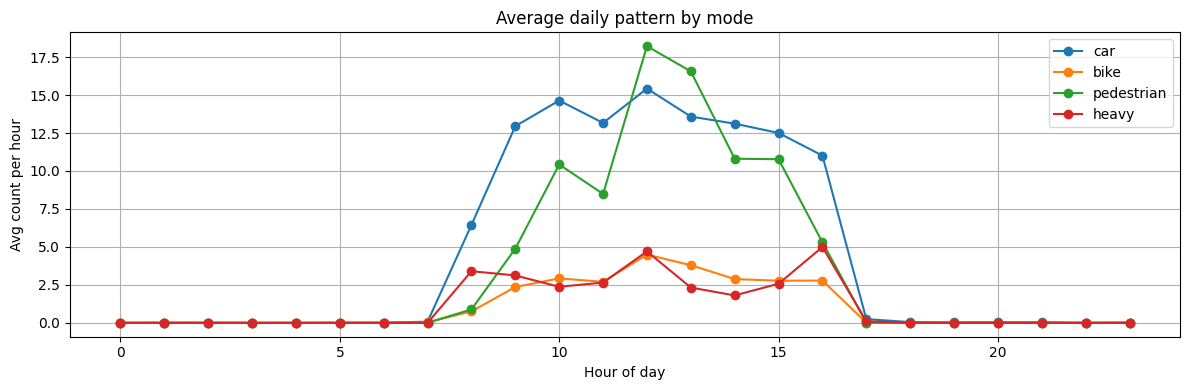

In [36]:
avg_hour_mode = (
    df_model.groupby("hour")[["car","bike","pedestrian","heavy"]]
    .mean()
)

plt.figure(figsize=(12,4))
for m in modes:
    plt.plot(avg_hour_mode.index, avg_hour_mode[m], marker="o", label=m)
plt.xlabel("Hour of day")
plt.ylabel("Avg count per hour")
plt.title("Average daily pattern by mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


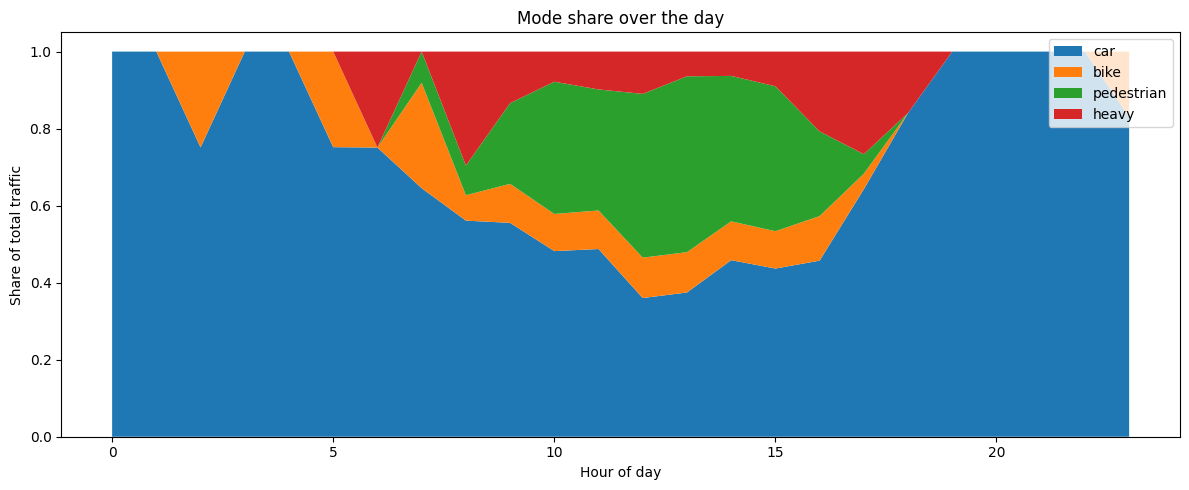

In [39]:
share = avg_hour_mode.div(avg_hour_mode.sum(axis=1), axis=0)

plt.figure(figsize=(12,5))
plt.stackplot(
    share.index,
    [share[m] for m in modes],
    labels=modes
)
plt.xlabel("Hour of day")
plt.ylabel("Share of total traffic")
plt.title("Mode share over the day")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


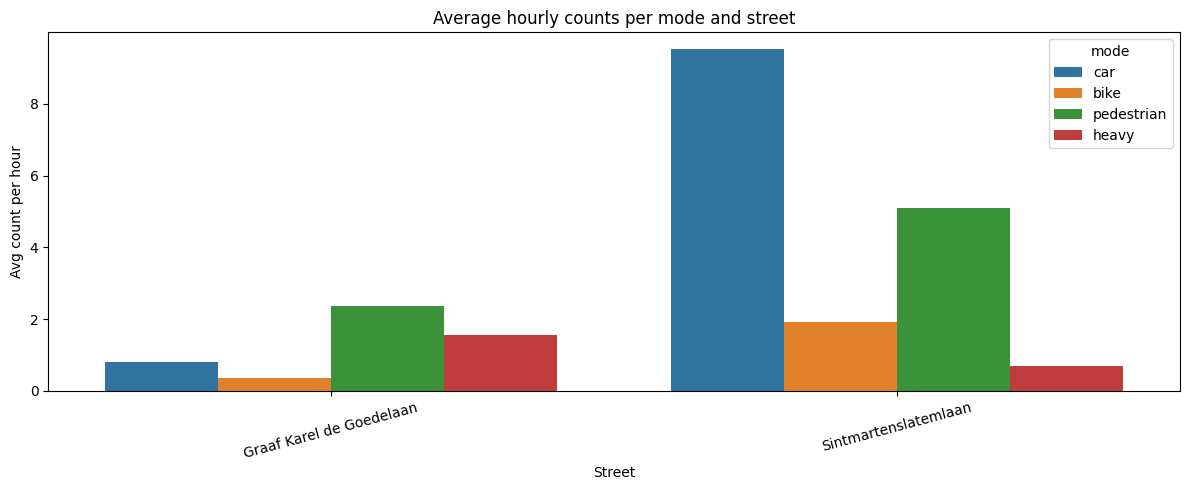

In [41]:
avg_street_mode = (
    df_model.groupby("street_name")[["car","bike","pedestrian","heavy"]]
    .mean()
    .reset_index()
)

avg_street_mode_melt = avg_street_mode.melt(
    id_vars="street_name",
    value_vars=modes,
    var_name="mode",
    value_name="avg_per_hour"
)

plt.figure(figsize=(12,5))
sns.barplot(
    data=avg_street_mode_melt,
    x="street_name",
    y="avg_per_hour",
    hue="mode"
)
plt.title("Average hourly counts per mode and street")
plt.xlabel("Street")
plt.ylabel("Avg count per hour")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
